In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")#; Pkg.instantiate()

  Activating environment at `~/Desktop/M1_pro_Projects/Notch_EMT/SciML_Notch/Project.toml`


In [2]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, Optim
using DiffEqFlux, Flux
using Plots
gr()
using JLD2, FileIO
using Statistics
# Set a random seed for reproduceable behaviour
using Random
Random.seed!(1234)


  ** incremental compilation may be fatally broken for this module **



┌ Info: DataDrivenDiffEq : OccamNet is available.
└ @ DataDrivenDiffEq /Users/chentianchi/.julia/packages/DataDrivenDiffEq/hVSnE/src/DataDrivenDiffEq.jl:144


MersenneTwister(1234)

In [3]:
svname = "Notch_EMT_unknown_"

## Data generation
# function lotka!(du, u, p, t)
#     α, β, γ, δ = p
#     du[1] = α*u[1] - β*u[2]*u[1]
#     du[2] = γ*u[1]*u[2]  - δ*u[2]
# end

@parameters k0 k1 k2 d m p k pp kk δ α1 A t
@variables R(t) NR(t) M(t) MR(t) K1(t) Ha(t) H0(t) P2(t) Hr(t) K2(t) K3(t) 
D = Differential(t)
##
eqs = [ D(R)     ~ -A*R + NR - k1*M*R + k2*MR,
        D(NR)    ~ A*R - NR,
        D(M)     ~ -k1*M*R + k2*MR,
        D(MR)    ~ k1*M*R - k2*MR, 
        D(Ha)    ~ -d*Ha*K1 + H0*K3,
        D(K1) ~ k0*MR + k*Hr - δ*K1 + α1,
        D(H0)    ~ d*Ha*K1 - m*H0*P2 + Hr*K2 - H0*K3,
        D(P2)  ~ p*Hr - δ*P2 + α1,
        D(Hr)   ~ m*H0*P2 - Hr*K2, 
        D(K2) ~ kk*Ha - δ*K2 + α1,
        D(K3)   ~ pp*Ha - δ*K3 + α1  ]
@named sys = ODESystem(eqs)

Model sys with 11 equations
States (11):
  R(t)
  NR(t)
  M(t)
  MR(t)
⋮
Parameters (12):
  A
  k1
  k2
  d
⋮

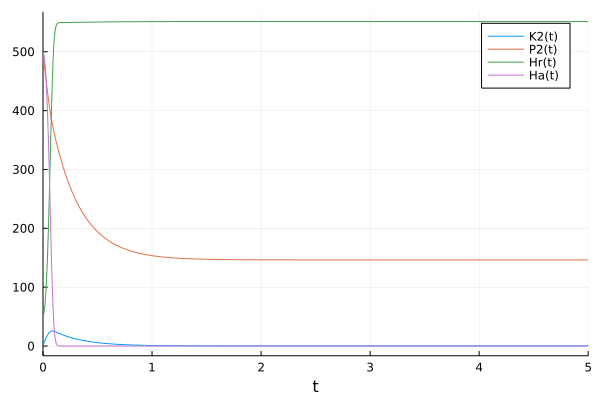

In [25]:
# Define the experimental parameter
tspan = (0.0f0, 5.0f0)
u0 = [6.0, 0.0, 6.0, 40.0, 500.0, 0.6876, 0.678, 500.0, 50.6344, 1.0, 2.0]
p_ = [10.0, 1.0, 1.0, 0.2, 0.53, 1.8, 3.77, 19.08, 19.08, 1.0, 1.0, 0.0]
prob = ODEProblem(sys, u0, tspan, p_, jac = true)
solution = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 0.01)

plot(solution, vars = [K2, P2, Hr, Ha])


In [26]:
# Ideal data
X = Array(solution)
t = solution.t


501-element Vector{Float32}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 4.92
 4.93
 4.94
 4.95
 4.96
 4.97
 4.98
 4.99
 5.0

In [29]:

# Add noise in terms of the mean
x̄ = mean(X, dims = 11)
noise_magnitude = Float32(5e-3)
Xₙ = X .+ (noise_magnitude * x̄) .* randn(eltype(X), size(X))



11×501 Matrix{Float64}:
   5.99639     9.26335     11.5629    …    10.9356        10.9437
   0.0         0.0759119    0.177863       10.9272        11.0163
   6.03149     9.25174     11.6711         22.0524        21.7254
  40.1062     36.692       34.3614         23.9922        23.9691
 500.718     493.159      480.111           6.95067e-6     6.87349e-6
   0.694784   11.4427      23.6592    …  2800.61        2791.04
   0.685574    0.156224     0.3345          0.0278626      0.0278829
 500.04      479.53       463.216         147.049        144.891
  50.5718     56.6961      74.1507        553.891        552.008
   1.00428     5.80001     10.4784          0.139969       0.141399
   2.0194      1.94331      1.87143   …     0.141529       0.13931

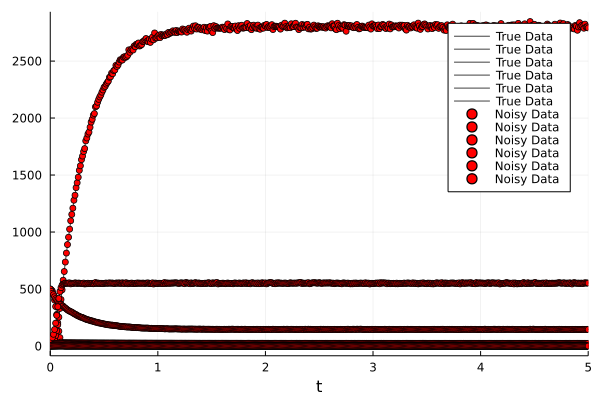

In [31]:

plot(solution, alpha = 0.75, color = :black, label = ["True Data" nothing])
scatter!(t, transpose(Xₙ), color = :red, label = ["Noisy Data" nothing])


In [45]:

## Define the network
# Gaussian RBF as activation
rbf(x) = exp.(-(x.^2))

# Multilayer FeedForward
U = FastChain(
    FastDense(11,15,rbf), FastDense(15,15, rbf), FastDense(15,15, rbf), FastDense(15,2)
)
# Get the initial parameters
p = initial_params(U)

692-element Vector{Float32}:
 -0.064331
  0.10249383
 -0.19661705
  0.024439078
  0.08001212
 -0.28528932
  0.3917714
  0.42393228
  0.20709541
  0.21247627
  ⋮
  0.5887698
  0.54781747
  0.3101474
  0.1279188
 -0.5489714
  0.08965101
  0.15492222
  0.0
  0.0

In [46]:
# Define the hybrid model
# function ude_dynamics!(du,u,p,t, p_true)
#   R, NR, M, MR, K1, Ha, H0, P2, Hr, K2, K3 = u
#   k0, p_true[2], p_true[3], d, m, p, k, pp, kk, δ, α1, A = p_true
#   û = U(u, p) # Network prediction
#   du[1]  = -A*R + NR - k1*M*R + k2*MR
#   du[2]  = A*R - NR
#   du[3]  = -k1*M*R + k2*MR 
#   du[4]  = k1*M*R - k2*MR 
#   du[5]  = -d*Ha*K1 + H0*K3
#   du[6]  = k0*MR + k*Hr -δ*K1 + α1
#   du[7]  = d*Ha*K1 - û[1] + Hr*K2 - H0*K3
#   du[8]  = p*Hr - δ*P2 + α1
#   du[9]  = û[2] - Hr*K2 
#   du[10] = kk*Ha - δ*K2 + α1
#   du[11] = pp*Ha - δ*K3 + α1 
# end

function ude_dynamics!(du, u, p, t, p_true)
  R, NR, M, MR, K1, Ha, H0, P2, Hr, K2, K3 = u
  û = U(u, p) # Network prediction
  du[1]  = -p_true[12]*R + NR - p_true[2]*M*R + p_true[3]*MR
  du[2]  = p_true[12]*R - NR
  du[3]  = -p_true[2]*M*R + p_true[3]*MR 
  du[4]  = p_true[2]*M*R - p_true[3]*MR 
  du[5]  = -p_true[4]*Ha*K1 + H0*K3
  du[6]  = p_true[1]*MR + p_true[7]*Hr -p_true[10]*K1 + p_true[11]
  du[7]  = p_true[4]*Ha*K1 - û[1] + Hr*K2 - H0*K3
  du[8]  = p_true[6]*Hr - p_true[10]*P2 + p_true[11]
  du[9]  = û[2] - Hr*K2 
  du[10] = p_true[9]*Ha - p_true[10]*K2 + p_true[11]
  du[11] = p_true[8]*Ha - p_true[10]*K3 + p_true[11] 
end

ude_dynamics! (generic function with 1 method)

In [47]:
# Closure with the known parameter
nn_dynamics!(du,u,p,t) = ude_dynamics!(du,u,p,t,p_)
# Define the problem
prob_nn = ODEProblem(nn_dynamics!,Xₙ[:, 1], tspan, p)
# Array(solve(prob_nn, Rosenbrock23(), u0 = X,
#                 tspan = (t[1], t[end]), saveat = t,
#                 abstol=1e-6, reltol=1e-6,
#                 sensealg = ForwardDiffSensitivity()
#                 ))

ODEProblem with uType Vector{Float64} and tType Float32. In-place: true
timespan: (0.0f0, 5.0f0)
u0: 11-element Vector{Float64}:
   5.996385967687786
   0.0
   6.031488377683712
  40.10616635301677
 500.7179363425758
   0.6947840840495575
   0.6855743186760841
 500.0400576975091
  50.571811067440315
   1.0042769194980221
   2.01939898194104

In [48]:
## Function to train the network
# Define a predictor
function predict(θ, X = Xₙ[:,1], T = t)
    Array(solve(prob_nn, Rosenbrock23(), u0 = X, p=θ,
                tspan = (T[1], T[end]), saveat = T,
                abstol=1e-6, reltol=1e-6,
                sensealg = ForwardDiffSensitivity()
                ))
end

# Simple L2 loss
function loss(θ)
    X̂ = predict(θ)
    @show size(Xₙ)
    @show size(X̂)
    sum(abs2, Xₙ .- X̂)
end

# Container to track the losses
losses = Float64[]

# Callback to show the loss during training
callback(θ,l) = begin
    push!(losses, l)
    if length(losses)%50==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    false
end

callback (generic function with 1 method)

In [49]:
## Training

# First train with ADAM for better convergence -> move the parameters into a
# favourable starting positing for BFGS
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.1f0), cb=callback, maxiters = 20)
println("Training loss after $(length(losses)) iterations: $(losses[end])")
# # Train with BFGS
# res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01f0), cb=callback, maxiters = 10000)
# println("Final training loss after $(length(losses)) iterations: $(losses[end])")


DimensionMismatch: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 501 and 52")